In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import poisson, binom, nbinom, lognorm, gamma
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

from functions2 import *

In [2]:
data = pd.read_csv('claim_data_group3_2024.csv')

data.set_index('IDpol', inplace=True)
data

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1093259.0,0.0,1.00,C,6.0,2.0,76.0,62.0,B12,Regular,306.0,R82,0.0
5026741.0,0.0,0.54,F,5.0,3.0,56.0,50.0,B12,Diesel,27000.0,R11,0.0
1081095.0,0.0,0.25,C,7.0,3.0,36.0,50.0,B5,Diesel,222.0,R24,0.0
3062789.0,0.0,1.00,C,6.0,4.0,58.0,69.0,B1,Regular,229.0,R53,0.0
4114350.0,0.0,1.00,A,4.0,14.0,67.0,50.0,B2,Regular,10.0,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6069891.0,0.0,0.52,A,4.0,1.0,63.0,95.0,B12,Regular,42.0,R74,0.0
6009212.0,0.0,0.70,E,10.0,5.0,65.0,52.0,B12,Regular,4348.0,R72,0.0
4013191.0,0.0,0.36,D,6.0,3.0,51.0,50.0,B12,Diesel,1955.0,R94,0.0


In [3]:
# split the data into 4 datasets
risk1, risk2 = train_test_split(data, test_size=0.5, random_state=42)
risk1, risk3 = train_test_split(risk1, test_size=0.5, random_state=42)
risk2, risk4 = train_test_split(risk2, test_size=0.5, random_state=42)
# List of datasets
datasets = [risk1, risk2, risk3, risk4]
dataset_names = ['risk1', 'risk2', 'risk3', 'risk4']



### Analysis for Risk Group 1 ###



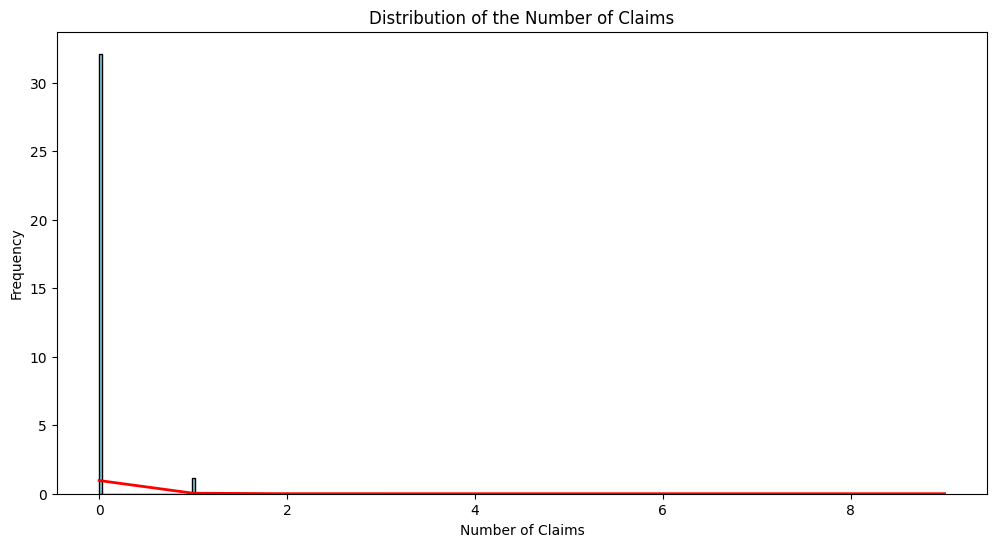

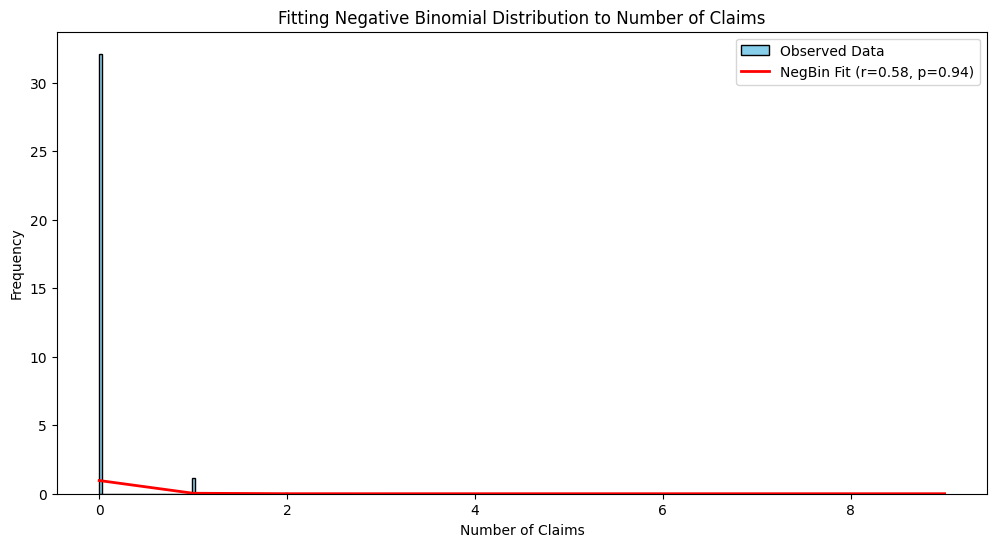

Poisson AIC: 8187.487579677271, BIC: 8195.614210781121
Negative Binomial AIC: 8156.410451853689, BIC: 8172.663714061389


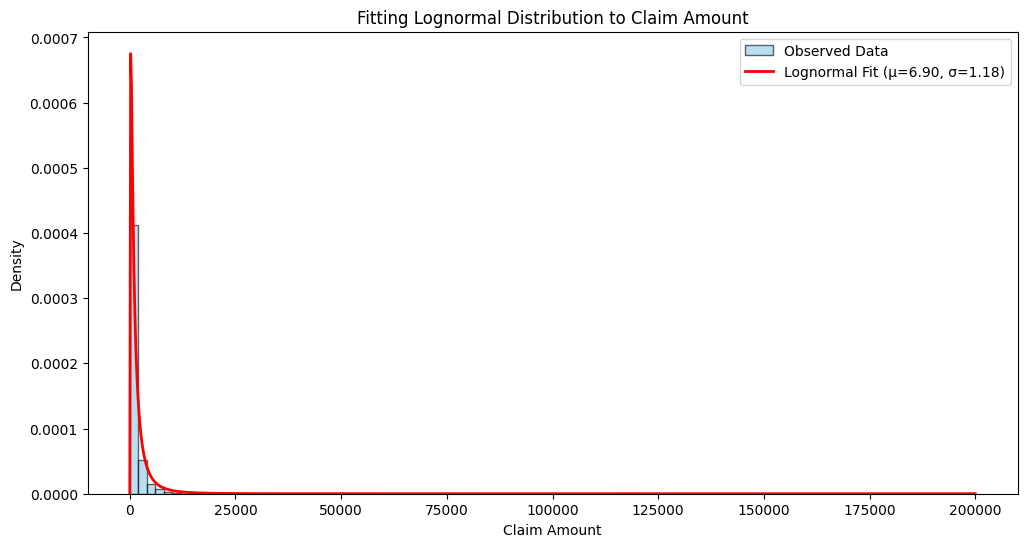

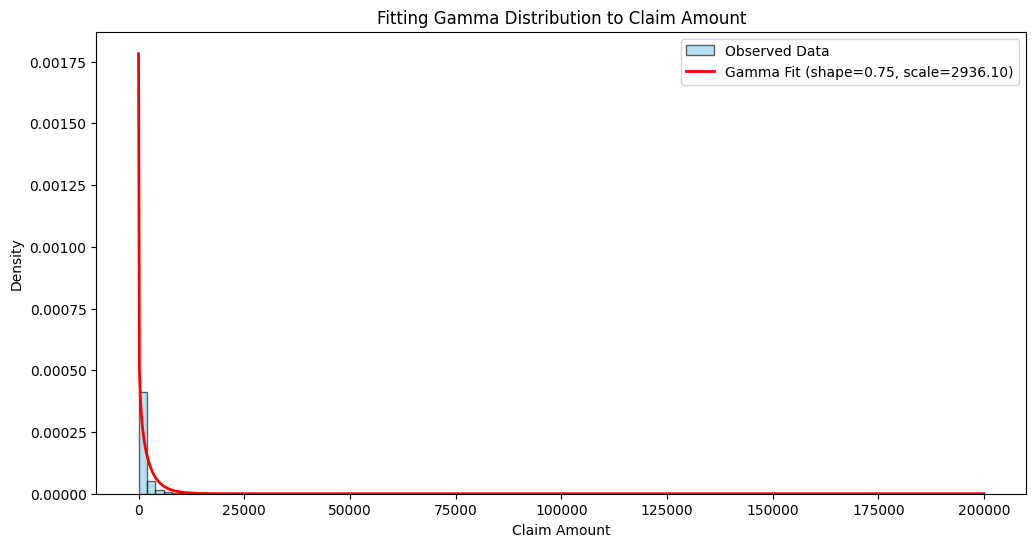

Lognormal AIC: 15376.060569200417, BIC: 15385.678647812503
Gamma AIC: 15707.618592515833, BIC: 15717.23667112792
Mean Total Loss: 64.18
Median Total Loss: 0.00
95th Percentile of Total Loss: 104.72
99th Percentile of Total Loss: 1973.04


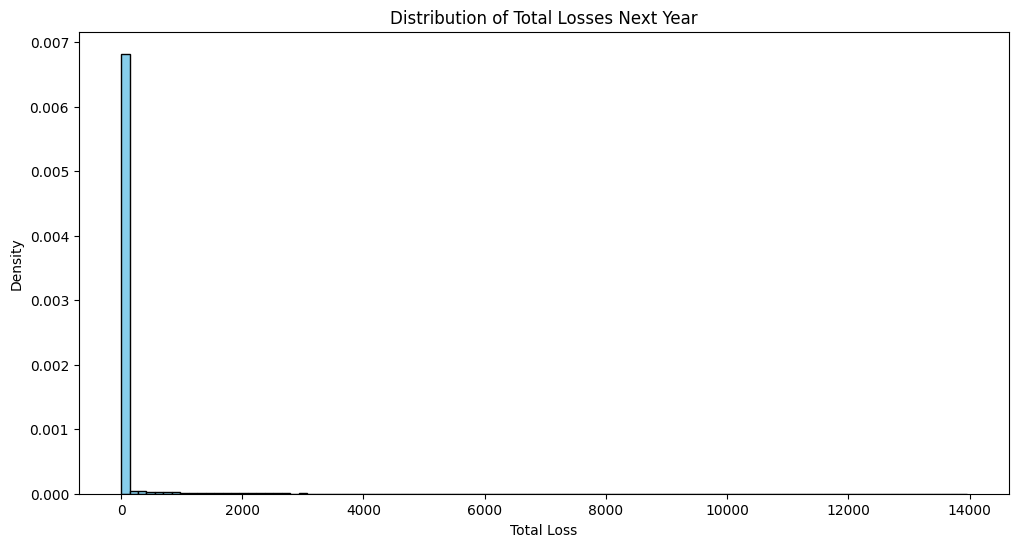

In [4]:
# Analysis for Risk Group 1

print(f"\n\n### Analysis for Risk Group 1 ###\n")

train_data = risk1.copy()   

lambda_poisson, poisson_dist = fit_and_plot_poisson(train_data)
r, p, neg_bin_dist = fit_and_plot_negbin(train_data)

# Step 3: Calculate AIC and BIC for claim frequency distributions
aic_poisson, bic_poisson = calculate_aic_bic(poisson_dist, train_data['ClaimNb'], 'pmf')
aic_negbin, bic_negbin = calculate_aic_bic(neg_bin_dist, train_data['ClaimNb'], 'pmf')
print(f'Poisson AIC: {aic_poisson}, BIC: {bic_poisson}')
print(f'Negative Binomial AIC: {aic_negbin}, BIC: {bic_negbin}')

# Determine the best frequency distribution based on BIC (better than AIC for goodness of fit)
if bic_poisson < bic_negbin:
    best_frequency_dist = 'Poisson'
    best_lambda = lambda_poisson
else:
    best_frequency_dist = 'Negative Binomial'
    best_r = r
    best_p = p

# Fit and plot Lognormal and Gamma distributions to ClaimAmount
lognorm_dist = fit_and_plot_lognormal(train_data)
shape_lognorm, loc_lognorm, scale_lognorm = lognorm.fit(train_data['ClaimAmount'][train_data['ClaimAmount'] > 0])  # Extract Lognormal parameters

gamma_dist = fit_and_plot_gamma(train_data)
shape_gamma, loc_gamma, scale_gamma = gamma.fit(train_data['ClaimAmount'][train_data['ClaimAmount'] > 0], floc=0)  # Extract Gamma parameters

# Calculate AIC and BIC for Lognormal and Gamma distributions
positive_claims = train_data['ClaimAmount'][train_data['ClaimAmount'] > 0]
aic_lognorm, bic_lognorm = calculate_aic_bic(lognorm_dist, positive_claims, 'pdf')
aic_gamma, bic_gamma = calculate_aic_bic(gamma_dist, positive_claims, 'pdf')
print(f'Lognormal AIC: {aic_lognorm}, BIC: {bic_lognorm}')
print(f'Gamma AIC: {aic_gamma}, BIC: {bic_gamma}')

# Determine the best severity distribution based on BIC
if bic_lognorm < bic_gamma:
    best_severity_dist = 'Lognormal'
    shape, scale = shape_lognorm, scale_lognorm
else:
    best_severity_dist = 'Gamma'
    shape, scale = shape_gamma, scale_gamma


# Monte Carlo simulation to forecast total losses for the next year using the best distributions
if best_frequency_dist == 'Poisson':
    monte_carlo_simulation(best_lambda, shape, scale)
else:
    monte_carlo_simulation(best_r, shape, scale, n_claims_dist='Negative Binomial', p=best_p)


In [5]:
'''
# Loop through each dataset
for i, dataset in enumerate(datasets):
    print(f"\n\n### Analysis for {dataset_names[i]} ###\n")
    
    # Step 1: Split the dataset into training and validation sets (70% train, 30% validation)
    train_data, valid_data = train_test_split(dataset, test_size=0.3, random_state=42)
    
    # Step 2: Fit and plot Poisson and Negative Binomial distributions
    lambda_poisson, poisson_dist = fit_and_plot_poisson(train_data)
    r, p, neg_bin_dist = fit_and_plot_negbin(train_data)

    # Step 3: Calculate log-likelihood for claim frequency distributions
    aic_poisson, bic_poisson = calculate_aic_bic(poisson_dist, train_data['ClaimNb'], 'pmf')
    aic_negbin, bic_negbin = calculate_aic_bic(neg_bin_dist, train_data['ClaimNb'], 'pmf')
    print(f'Poisson AIC: {aic_poisson}, BIC: {bic_poisson}')
    print(f'Negative Binomial AIC: {aic_negbin}, BIC: {bic_negbin}')

    # Step 4: Simulate claim frequency on the validation set
    simulate_frequency(valid_data, lambda_poisson, r, p)

    # Step 5: Fit and plot Lognormal and Gamma distributions to ClaimAmount
    lognorm_dist = fit_and_plot_lognormal(train_data)
    gamma_dist = fit_and_plot_gamma(train_data)

    # Calculate AIC and BIC for Lognormal and Gamma distributions
    positive_claims = train_data['ClaimAmount'][train_data['ClaimAmount'] > 0]
    aic_lognorm, bic_lognorm = calculate_aic_bic(lognorm_dist, positive_claims, 'pdf')
    aic_gamma, bic_gamma = calculate_aic_bic(gamma_dist, positive_claims, 'pdf')
    print(f'Lognormal AIC: {aic_lognorm}, BIC: {bic_lognorm}')
    print(f'Gamma AIC: {aic_gamma}, BIC: {bic_gamma}')

    # Step 7: Simulate claim severity on the validation set
    simulate_severity(valid_data, lognorm_dist, gamma_dist)

    # Step 8: Monte Carlo simulation to forecast total losses for the next year
    # Using Gamma distribution parameters from train_data (shape and scale)
    shape, loc, scale = gamma.fit(train_data['ClaimAmount'][train_data['ClaimAmount'] > 0], floc=0)
    monte_carlo_simulation(lambda_poisson, shape, scale)
    '''


'\n# Loop through each dataset\nfor i, dataset in enumerate(datasets):\n    print(f"\n\n### Analysis for {dataset_names[i]} ###\n")\n    \n    # Step 1: Split the dataset into training and validation sets (70% train, 30% validation)\n    train_data, valid_data = train_test_split(dataset, test_size=0.3, random_state=42)\n    \n    # Step 2: Fit and plot Poisson and Negative Binomial distributions\n    lambda_poisson, poisson_dist = fit_and_plot_poisson(train_data)\n    r, p, neg_bin_dist = fit_and_plot_negbin(train_data)\n\n    # Step 3: Calculate log-likelihood for claim frequency distributions\n    aic_poisson, bic_poisson = calculate_aic_bic(poisson_dist, train_data[\'ClaimNb\'], \'pmf\')\n    aic_negbin, bic_negbin = calculate_aic_bic(neg_bin_dist, train_data[\'ClaimNb\'], \'pmf\')\n    print(f\'Poisson AIC: {aic_poisson}, BIC: {bic_poisson}\')\n    print(f\'Negative Binomial AIC: {aic_negbin}, BIC: {bic_negbin}\')\n\n    # Step 4: Simulate claim frequency on the validation set\n   